Importing Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [11]:
df = pd.read_csv('/Users/boczagaba/PycharmProjects/energy_cons_pred/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

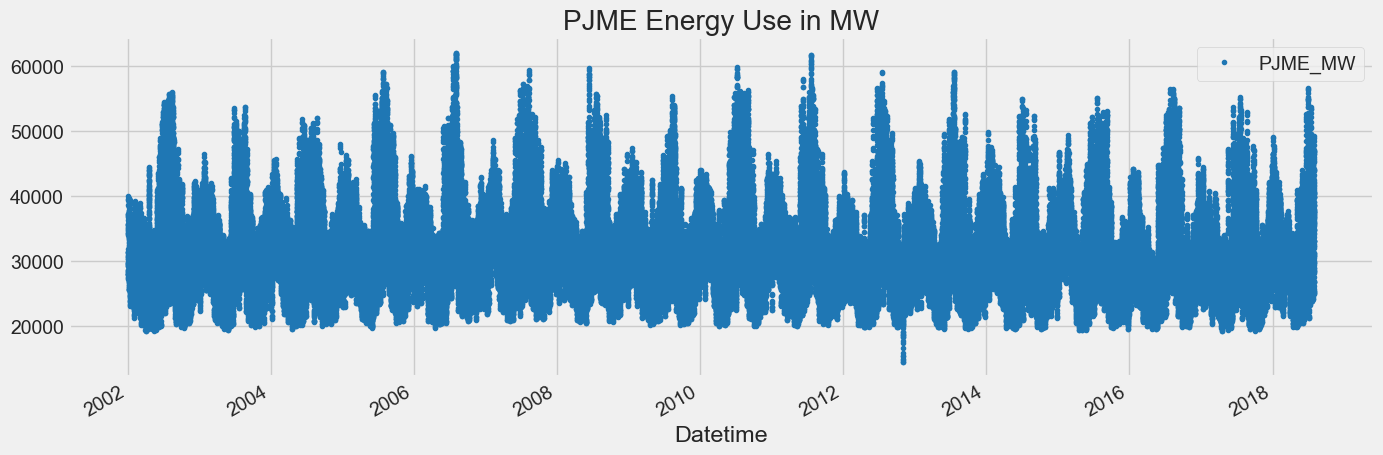

In [12]:
df.plot(style = '.',
        figsize = (15, 5),
        color = color_pal[0],
        title = 'PJME Energy Use in MW')

Removing Outliers

<Axes: ylabel='Frequency'>

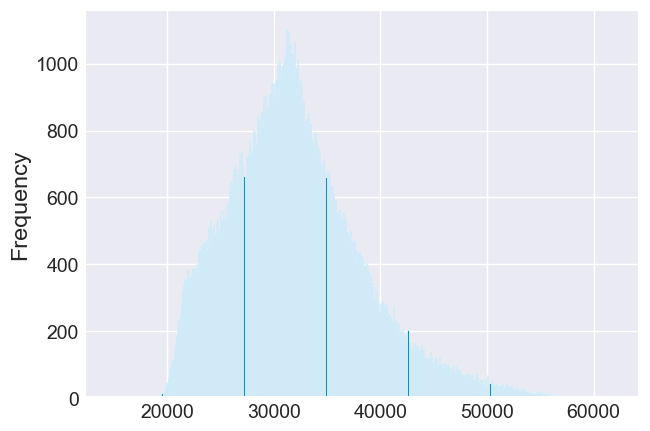

In [25]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

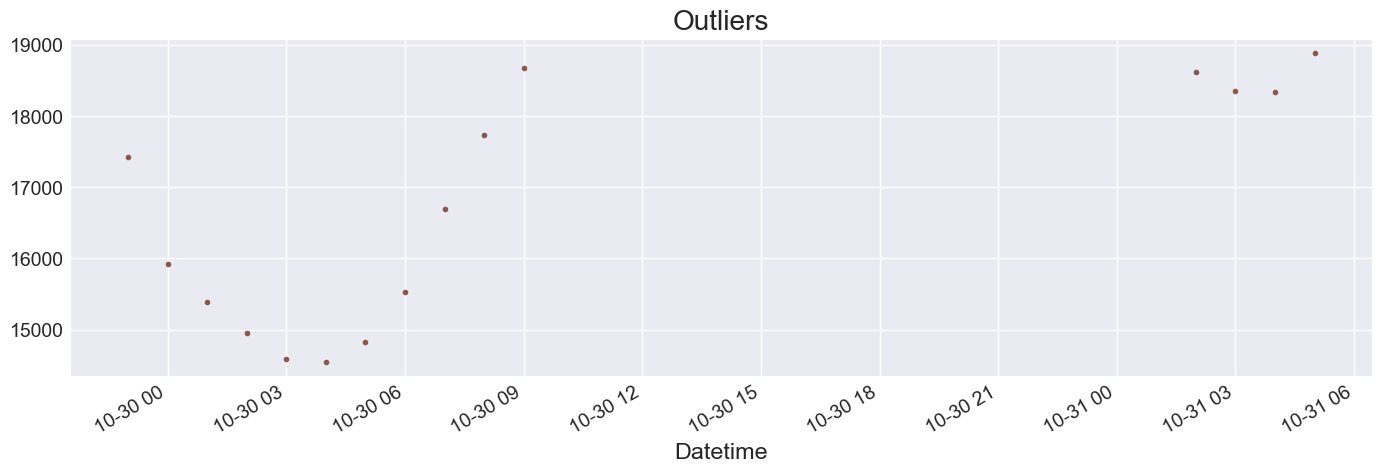

In [26]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [27]:
df = df.query('PJME_MW > 19_000').copy()

Splitting Data Into Train and Test Set

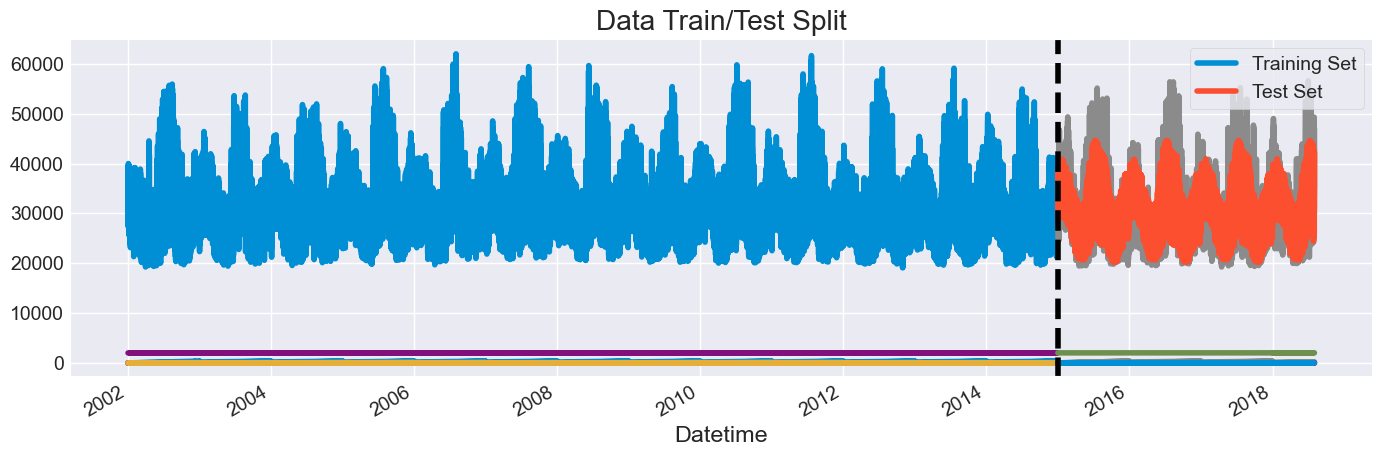

In [29]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Time Series Cross Validation

In [30]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 24 * 365 * 1, gap = 24)
df = df.sort_index()

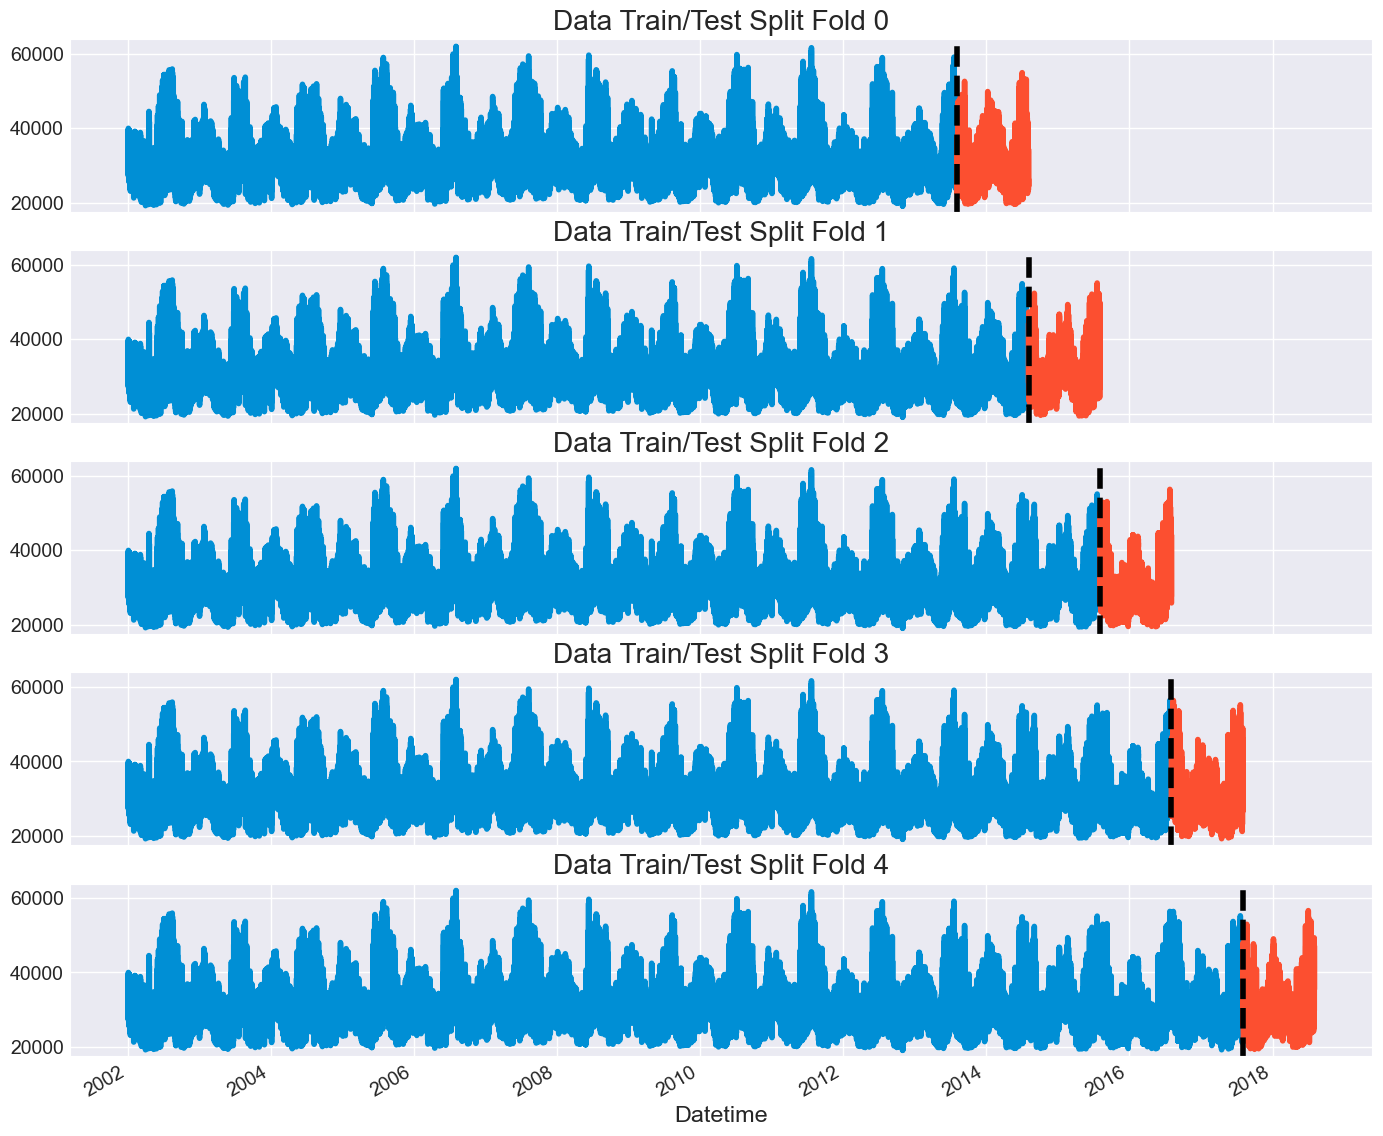

In [31]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Creating Features

In [32]:
def create_features(df):
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week
        return df

df = create_features(df)

Lag Features

In [33]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [34]:
df = add_lags(df)

Create Model and Train Using Cross Validation

In [35]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
                'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    Y_train = train[TARGET]

    X_test = test[FEATURES]
    Y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_test, Y_test)],
            verbose=100)

    Y_pred = reg.predict(X_test)
    predictions.append(Y_pred)
    score = np.sqrt(mean_squared_error(Y_test, Y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901
[100]	validation_0-rmse:12532.43235	validation_1-rmse:11904.58782


/Users/boczagaba/PycharmProjects/energy_cons_pred/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5744.95222	validation_1-rmse:5356.84300
[300]	validation_0-rmse:3871.90369	validation_1-rmse:3892.59716
[400]	validation_0-rmse:3435.02956	validation_1-rmse:3754.33238
[445]	validation_0-rmse:3365.94502	validation_1-rmse:3757.55814
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679
[100]	validation_0-rmse:12513.53851	validation_1-rmse:12226.39459


/Users/boczagaba/PycharmProjects/energy_cons_pred/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5755.01846	validation_1-rmse:5651.27874
[300]	validation_0-rmse:3906.82210	validation_1-rmse:3927.45255
[400]	validation_0-rmse:3478.17872	validation_1-rmse:3596.84442
[500]	validation_0-rmse:3352.66618	validation_1-rmse:3523.07822
[600]	validation_0-rmse:3296.70510	validation_1-rmse:3487.82916
[700]	validation_0-rmse:3257.73321	validation_1-rmse:3468.06020
[800]	validation_0-rmse:3222.25681	validation_1-rmse:3445.37604
[900]	validation_0-rmse:3192.52469	validation_1-rmse:3432.72311
[999]	validation_0-rmse:3165.63907	validation_1-rmse:3425.71868
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153
[100]	validation_0-rmse:12498.81929	validation_1-rmse:11133.77575


/Users/boczagaba/PycharmProjects/energy_cons_pred/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5749.69417	validation_1-rmse:4808.52984
[300]	validation_0-rmse:3914.33408	validation_1-rmse:3542.09733
[400]	validation_0-rmse:3492.92067	validation_1-rmse:3488.41143
[402]	validation_0-rmse:3489.21578	validation_1-rmse:3490.11888
[0]	validation_0-rmse:32528.18588	validation_1-rmse:31474.51358
[100]	validation_0-rmse:12462.18076	validation_1-rmse:12018.20453


/Users/boczagaba/PycharmProjects/energy_cons_pred/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5737.83720	validation_1-rmse:5794.21490
[300]	validation_0-rmse:3914.73269	validation_1-rmse:4385.31312
[400]	validation_0-rmse:3497.45006	validation_1-rmse:4169.33851
[500]	validation_0-rmse:3382.37925	validation_1-rmse:4114.28353
[600]	validation_0-rmse:3323.85812	validation_1-rmse:4100.91932
[700]	validation_0-rmse:3282.58032	validation_1-rmse:4088.30411
[770]	validation_0-rmse:3258.81926	validation_1-rmse:4084.53285
[0]	validation_0-rmse:32461.76096	validation_1-rmse:31462.58329
[100]	validation_0-rmse:12445.41304	validation_1-rmse:11962.08478


/Users/boczagaba/PycharmProjects/energy_cons_pred/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:30:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5751.81541	validation_1-rmse:5613.52924
[300]	validation_0-rmse:3951.49516	validation_1-rmse:4150.66012
[400]	validation_0-rmse:3540.50142	validation_1-rmse:4001.74842
[438]	validation_0-rmse:3483.13324	validation_1-rmse:4004.04351


In [36]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3746.8895
Fold scores:[np.float64(3753.6176552727843), np.float64(3425.271376428151), np.float64(3473.313333085868), np.float64(4083.674535861454), np.float64(3998.5707082342237)]


Set Up Model for Predicting

In [37]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
Y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                       n_estimators = 500,
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.01)

reg.fit(X_all, Y_all,
        eval_set = [(X_all, Y_all)], verbose = 100)

[0]	validation_0-rmse:32403.50092


/Users/boczagaba/PycharmProjects/energy_cons_pred/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:33:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.68377
[200]	validation_0-rmse:5752.98750
[300]	validation_0-rmse:3972.54751
[400]	validation_0-rmse:3572.30494
[499]	validation_0-rmse:3457.72065


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [38]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

Dataframe with Future Dates

In [39]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [40]:
future_w_features = df_and_future.query('isFuture').copy()

Predicting the Future

In [41]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

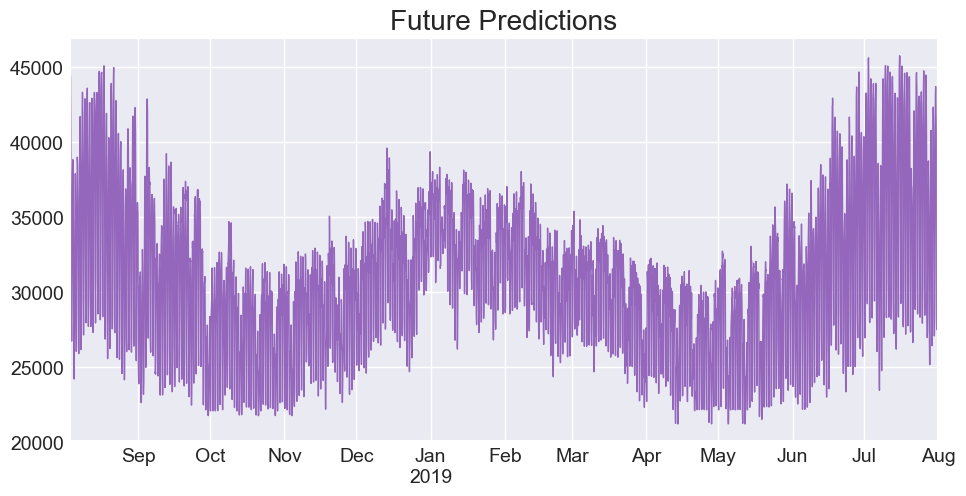

In [42]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

Saving Model

In [43]:
reg.save_model('model.json')